# ReLU Transform on Masked Image

Processing an image through a neural network for stylistic effects and education.

---


In [17]:
import json
import utils
import datetime
import rangetest
import importlib
import scrapbook
import functools
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from sklearn import metrics
import matplotlib.pyplot as plt
from IPython.core import display

importlib.reload(rangetest)
plt.style.use('dark_background')

In [92]:
data_folder = 'data/cat-attack-masked-medium-gray/'
layer_sizes = [2] + [32, 16, 8, 4] + [1]
bias_initializer = 'zeros'
batch_norm = "pre"
use_residuals = True

In [93]:
# utils
def palettize(palette, color):
    """ Rounds a color to the closest in a given palette.
    
    Args:
        palette (np 2D): Tensor of shape (color index, color values).
            color values can be 1 for grayscale or 3 for RGB.
        color (np 1D): Either RGB tuple or a single grayscale value.
        
    Returns:
        Closes matching palette color.
    """
    col_idx = np.argmin(np.sum((color[np.newaxis] - palette)**2, axis=1))
    return palette[col_idx]


def find_edges(img, tol):
    """ Find edges in the picture. 
    
    Args:
        img (2D array): a grayscale image.
        tol (float): A small number, color that differs by less than tol
           will be considered same.
           
    Returns:
        2D array which is 0 if there is an edge.
    """    
    # equals to 0 if there is a change
    x1 = np.diff(img, n=1, axis=0, prepend=1) < tol
    x2 = np.diff(img, n=1, axis=1, prepend=1) < tol
    return (x1[:,:] & x2[:,:]).astype("float32")


def find_neighbours(img, tol):
    """ For each point compute number of different neighbours. 
    
    Args:
        img (2D array): a grayscale image.
        tol (float): A small number, color that differs by less than tol
           will be considered same.
           
    Returns:
        2D array where each value is an integer between 0 and 8.
        This value is the number of neighbours different from this pixel.
        The neighbours are taken to be the square around the given pixel.
    """ 
    # helper function to compute equality up to a tolerance
    def eq(a, b):
        return abs(a-b) < tol

    
    edges = np.zeros_like(img)
    for i in range(1, img.shape[0]-1):
        for j in range(1, img.shape[1]-1):
            this_grad = img[i,j]
            edges[i,j] += not eq(this_grad, img[i+1,j])
            edges[i,j] += not eq(this_grad, img[i-1,j])
            edges[i,j] += not eq(this_grad, img[i-1,j+1])
            edges[i,j] += not eq(this_grad, img[i,  j+1])
            edges[i,j] += not eq(this_grad, img[i+1,j+1])
            edges[i,j] += not eq(this_grad, img[i-1,j-1])
            edges[i,j] += not eq(this_grad, img[i,  j-1])
            edges[i,j] += not eq(this_grad, img[i+1,j-1])
    return edges

In [94]:
# Test utils

def test_palettize_grayscale():
    """ Tests palettize on a 3 colors grayscale palette.
    """
    pal = np.array([[0], [0.5], [1]])
    assert palettize(pal, np.array([0.])) == 0, "Closest palette color should be 0"
    assert palettize(pal, np.array([0.1])) == 0, "Closest palette color should be 0"
    assert palettize(pal, np.array([0.2])) == 0, "Closest palette color should be 0"
    assert palettize(pal, np.array([0.26])) == 0.5, "Closest palette color should be 0.5"
    assert palettize(pal, np.array([0.8])) == 1, "Closest palette color should be 1"

def test_find_edges():
    """ Tests find_edges with dummy data. """
    np.testing.assert_almost_equal(
        find_edges([
            [0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0]], 1e-3),
        [[1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1]],
        err_msg="not expected result")

    np.testing.assert_almost_equal(
        find_edges([
            [0, 0, 0, 0, 0],
            [0, 0, 1, 1, 0]], 1e-3),
        [[1, 1, 1, 1, 1],
        [1, 1, 0, 0, 1]],
        err_msg="not expected result"
    )
    
    
def test_find_neighbours():
    """ Test find_neighbours on dummy data. """
    np.testing.assert_almost_equal(
            find_neighbours(np.array([
                [0, 0, 0, 0, 0],
                [0, 0, 1, 0, 0],
                [0, 0, 0, 0, 0]]), 1e-3),
            [[0, 0, 0, 0, 0],
            [0, 1, 8, 1, 0],
            [0, 0, 0, 0, 0]],
            err_msg="not expected result")

    np.testing.assert_almost_equal(
            find_neighbours(np.array([
                [0, 0, 0, 0, 0],
                [0, 0, 1, 1, 0],
                [0, 0, 0, 0, 0]]), 1e-3),
            [[0, 0, 0, 0, 0],
            [0, 1, 7, 7, 0],
            [0, 0, 0, 0, 0]],
            err_msg="not expected result")
    
test_palettize_grayscale()
test_find_edges()
test_find_neighbours()

### Run parameters

In [95]:
print({
    'data_folder': data_folder,
    'layer_sizes': layer_sizes,
    'bias_initializer': bias_initializer,
    'batch_norm': batch_norm,
    'use_residuals': use_residuals
})

{'data_folder': 'data/cat-attack-masked-medium-gray/', 'layer_sizes': [2, 32, 16, 8, 4, 1], 'bias_initializer': 'zeros', 'batch_norm': 'pre', 'use_residuals': True}


In [96]:
# load information about the transformed data
with open(data_folder+'/meta.json', 'r') as f:
    metadata = json.load(f)
    
# load the img arrays
with np.load(data_folder+'/pic_long.npz') as data:
    pic_long_norm = data['pic_long_norm']
    pix_loc_norm = data['pix_loc_long_norm']
    weight_long = data['weight_long']
    
height, width, n_channels = metadata['target_size']
n_pixels = height * width
target_size = metadata['target_size']
av_color = np.array(metadata['av_color'])

## Setting up the model and training

---

In [97]:
# clear logs and tf graphs
!rm -rf logs
keras.backend.clear_session()

In [98]:
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
# file_writer.set_as_default()

# class LRTensorBoard(keras.callbacks.TensorBoard):
#     """ This callback saves learning rate to tensorboard.
#     """
#     def __init__(self, log_dir, **kwargs): 
#         super().__init__(log_dir=log_dir, **kwargs)

#     def on_epoch_end(self, epoch, logs=None):
#         logs = logs or {}
#         logs.update({'lr': K.eval(self.model.optimizer.lr)})
#         super().on_epoch_end(epoch, logs)
        
# lr_tensorboard = LRTensorBoard(log_dir)

In [99]:
# building a MLP
model = None
model = utils.mlp_builder(layer_sizes, bias_initializer,
                    batch_norm=batch_norm, use_residuals=use_residuals)
model.compile(
    optimizer=keras.optimizers.Adam(), loss="mse")
# this object will hold the full training history
cumulated_history = {
    'loss': [],
    'lr': [],
    'batch': []
}

### Model architecture

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2)                 8         
_________________________________________________________________
dense (Dense)                (None, 32)                96        
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0     

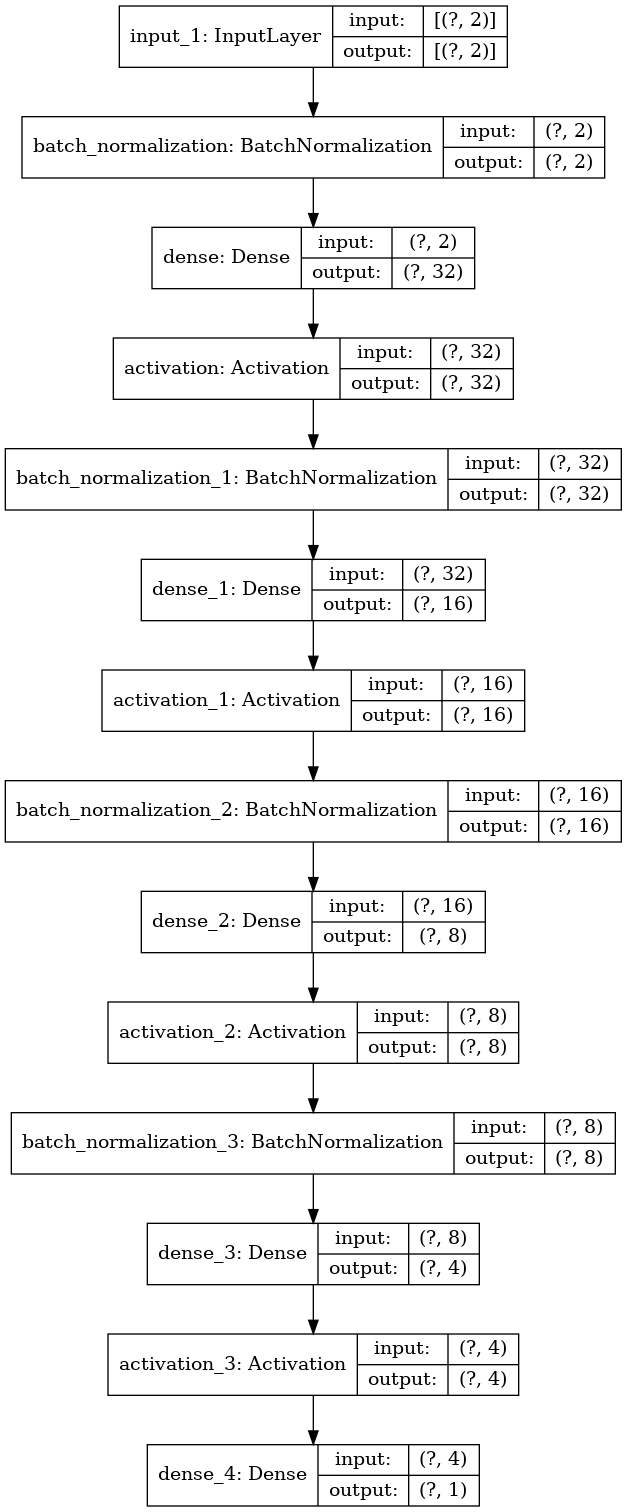

In [100]:
print(model.summary())
keras.utils.plot_model(model, show_shapes=True)

### Optimizer setting

In [101]:
print('Optimizer:', model.optimizer.__class__.__name__)
print(model.optimizer.get_config())

Optimizer: Adam
{'name': 'Adam', 'learning_rate': 0.001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


### Learning rate range test

In [102]:
batch_size = n_pixels // 3
print("Batch size:", batch_size)
print("Number of batches:", (n_pixels // batch_size) + n_pixels % batch_size)

Batch size: 10404
Number of batches: 3


In [126]:
range_test = rangetest.lr_range_test(model, pix_loc_norm, pic_long_norm,
             base_lr=0.000001, max_lr=0.02, n_steps=200, batch_size=batch_size)


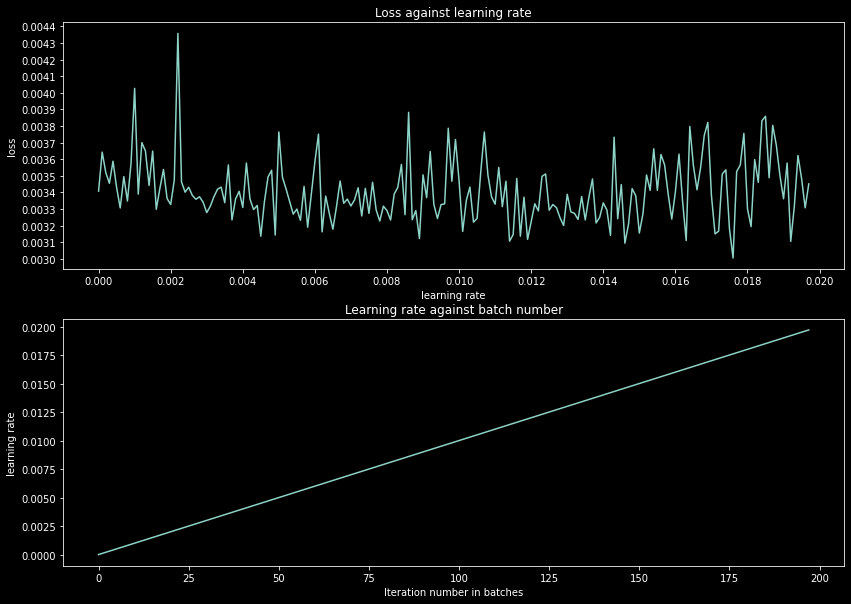

In [127]:
rangetest.show_lr_range_test(range_test, head=None, figsize=(14, 10))
# scrapbook.glue("lr_range_test", range_test, display=True)

In [128]:
clr = rangetest.CyclicLR(base_lr=0.0001, max_lr=0.003, step_size=250*n_pixels // batch_size, mode="triangular2")
keras_history = model.fit(
    pix_loc_norm, pic_long_norm, epochs=1000, batch_size=batch_size,
    callbacks=[clr], verbose=0, shuffle=True, sample_weight=weight_long[:,0]
    )

  ...
    to  
  ['...']


### Training curves

In [108]:
for k in cumulated_history:
    cumulated_history[k] += clr.history[k]
    
history_df = pd.DataFrame(cumulated_history)
# history_df = pd.DataFrame(clr.history)
history_df['epoch'] = np.cumsum(history_df.batch.values == 0)
history_df = history_df.groupby('epoch').mean().reset_index()

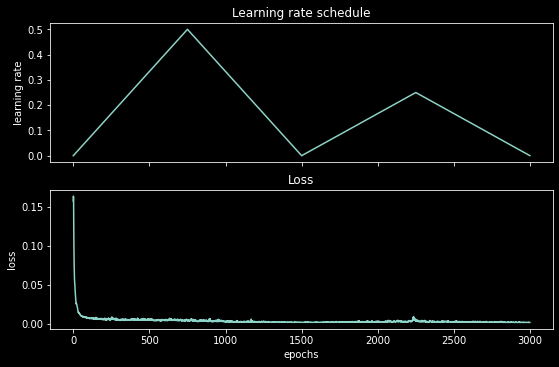

In [109]:
utils.viz_history(clr.history)
# viz_history(dict(history_df))

## Analyze model results

---


In [110]:
# compute the learned image
pred_long = model.predict(pix_loc_norm)

In [111]:
pred_long = model(pix_loc_norm.astype('float32'), training=True).numpy()

### Metrics

In [112]:
model_metrics = pd.DataFrame({
    'naive mse': metrics.mean_squared_error(
        pic_long_norm, np.zeros_like(pic_long_norm)
    ),
    'mse': metrics.mean_squared_error(pic_long_norm, pred_long),
    'naive mae': metrics.mean_absolute_error(
        pic_long_norm, np.zeros_like(pic_long_norm)
    ),
    'mae': metrics.mean_absolute_error(pic_long_norm, pred_long),
    'best_loss': np.min(clr.history['loss'])
    }, index=['value'])

with pd.option_context('precision', 3):
    display.display(display.HTML(model_metrics.to_html()))

In [113]:
print("MSE improvement (%) over naive:",
      ((model_metrics['mse'] - model_metrics['naive mse']) 
      / model_metrics['naive mse']).value)

MSE improvement (%) over naive: -0.9445882


### Reconstructed image

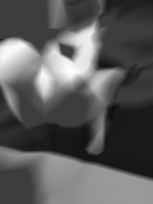

In [114]:
image.array_to_img(255*pred_long.reshape(target_size)+av_color[np.newaxis,:])

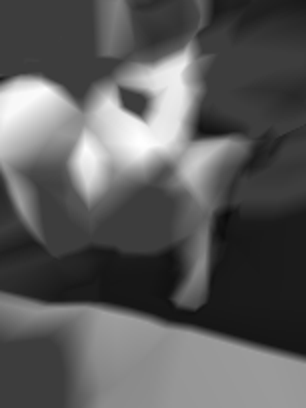

In [115]:
pil= image.array_to_img(255*pred_long.reshape(target_size)+av_color[np.newaxis,:])
pil.resize(size=(width*2, height*2))

### Network gradients

In [116]:
# compute the gradients
x_input = tf.convert_to_tensor(pix_loc_norm, dtype='float32')
with tf.GradientTape() as tape:
    tape.watch(x_input)
    y = model(x_input)
grad = tape.gradient(y, x_input)

# absolute norm of the gradient at each point
grad2d = np.sum(grad.numpy()**2, axis=1).reshape(height, width)

print("Number of unique gradients:", np.size(np.unique(grad.numpy(), axis=0)))
print("unique gradients Y direction:", np.size(np.unique(grad.numpy()[:, 0])))
print("unique gradients X direction:", np.size(np.unique(grad.numpy()[:, 1])))

Number of unique gradients: 3104
unique gradients Y direction: 1552
unique gradients X direction: 1552


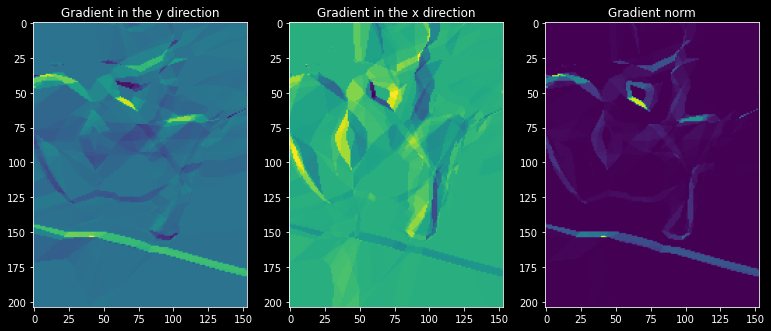

In [117]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 13/1.6))
ax1.imshow(grad.numpy().reshape(height, width, 2)[:,:,0])
ax1.set_title("Gradient in the y direction")
ax2.imshow(grad.numpy().reshape(height, width, 2)[:,:,1])
ax2.set_title("Gradient in the x direction")
ax3.imshow(grad2d)
ax3.set_title("Gradient norm")
None

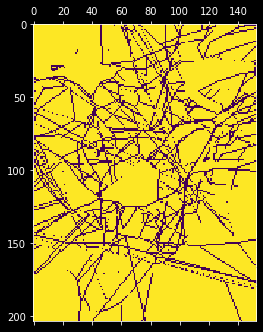

In [118]:
boundaries = find_neighbours(grad2d, 1e-3)<4
boundaries = find_edges(grad2d, 1e-3)
plt.matshow(boundaries)

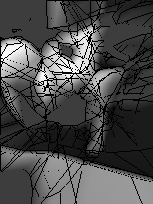

In [119]:
pil = image.array_to_img(boundaries[:,:, np.newaxis]*(255*pred_long.reshape(target_size)+av_color[np.newaxis,:]))
pil.resize(size=(width*1, height*1))

## Post process image

In [120]:
# we choose 100 random pixels...
proba = weight_long[:,0]**4
proba = proba/np.sum(proba)
chosen_pix = np.random.choice(len(pic_long_norm), 100, replace=False, p=proba)
# ... and make a palette out of their colors
pal = pic_long_norm[chosen_pix]
# palettize
pic_long_post = np.apply_along_axis(functools.partial(palettize, pal), axis=1, arr=pred_long)

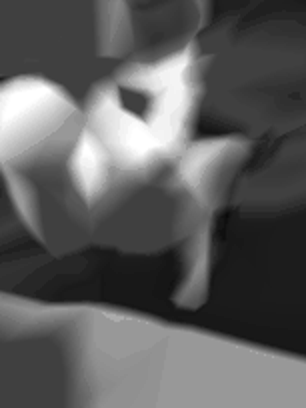

In [121]:
pil = image.array_to_img(255*pic_long_post.reshape(target_size)+av_color[np.newaxis,:])
pil.resize(size=(width*2, height*2))

In [129]:
now = datetime.datetime.strftime(datetime.datetime.now(), "%Y-%m-%d-%H:%M")
model_name = 'gray-medium-masked-32-16-8-4-1-[{}]'.format(now)
model.save(model_name)
print("Model saved to:", model_name)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: gray-medium-masked-32-16-8-4-1-[2020-05-08-15:49]/assets
Model saved to: gray-medium-masked-32-16-8-4-1-[2020-05-08-15:49]


In [132]:
!jupyter nbconvert "ReLU-me-masked.ipynb" --no-input --to markdown --output "gray-medium-masked-32-16-8-4-1.md"

[NbConvertApp] Converting notebook ReLU-me-masked.ipynb to markdown
[NbConvertApp] Support files will be in gray-medium-masked-32-16-8-4-1_files/
[NbConvertApp] Making directory gray-medium-masked-32-16-8-4-1_files
[NbConvertApp] Making directory gray-medium-masked-32-16-8-4-1_files
[NbConvertApp] Making directory gray-medium-masked-32-16-8-4-1_files
[NbConvertApp] Making directory gray-medium-masked-32-16-8-4-1_files
[NbConvertApp] Making directory gray-medium-masked-32-16-8-4-1_files
[NbConvertApp] Making directory gray-medium-masked-32-16-8-4-1_files
[NbConvertApp] Making directory gray-medium-masked-32-16-8-4-1_files
[NbConvertApp] Making directory gray-medium-masked-32-16-8-4-1_files
[NbConvertApp] Making directory gray-medium-masked-32-16-8-4-1_files
[NbConvertApp] Writing 8342 bytes to gray-medium-masked-32-16-8-4-1.md
